# Travel Planner AI

## Part 1: Introduction

Welcome to the Travel Planner AI project! This notebook demonstrates how to build a smart, AI-driven travel planning assistant using ChatGPT. 

## Objective:
The goal is to create an intelligent system that assists users in planning their trips. It will provide personalized travel itineraries, suggest destinations, recommend accommodations, and offer insights based on user preferences.

## Features:
- **Destination Recommendations:** Suggest places to visit based on user interests, budget, and time constraints.
- **Itinerary Creation:** Generate daily schedules tailored to the user's travel plans.

## Technologies Used:
- **OpenAI's GPT Model:** For natural language processing and conversational capabilities.
- **APIs:** To fetch live travel data, such as flights, accommodations, and activities.
- **Python Libraries:** For data processing, visualization, and integration with external services.

## How It Works:
1. Input user preferences (e.g., destination type, budget, duration, and travel dates).
2. Use AI to analyze and process the input.
3. Generate a comprehensive travel plan tailored to the user.
4. Provide suggestions and allow iterative adjustments based on feedback.

Let's get started on building your personalized AI travel assistant!


#### Project Background

Travel planning is a complex and time-consuming task that involves selecting destinations, booking accommodations, finding activities, and ensuring smooth transitions between locations. With the growing accessibility of travel options and information, travelers often face an overwhelming amount of choices, making it difficult to create efficient and enjoyable itineraries.

The advent of AI technologies, like ChatGPT, provides an opportunity to streamline this process. By leveraging machine learning, natural language processing, and APIs, we can develop an intelligent assistant capable of delivering personalized travel plans based on individual preferences, constraints, and real-time data.

This project aims to combine AI capabilities with travel data to create an automated, user-friendly Travel Planner that simplifies decision-making and enhances the overall travel experience.


#### Problem Statement

Planning a trip can be a daunting and time-consuming task due to several challenges:

1. **Information Overload:** Travelers are overwhelmed by vast amounts of data about destinations, accommodations, and activities.
2. **Lack of Personalization:** Most existing solutions provide generic recommendations that fail to meet individual preferences and constraints.
3. **Inefficiency:** Manually researching, comparing, and organizing travel details is tedious and error-prone.
4. **Limited Integration:** Current tools often address only specific aspects of travel, leaving users to manage the overall plan themselves.
5. **Dynamic Changes:** Travel plans frequently require adjustments due to unforeseen circumstances like weather or availability.

To address these issues, we aim to build a Travel Planner AI that simplifies decision-making, provides personalized recommendations, and adapts dynamically to user needs, ensuring a seamless and enjoyable travel experience.


#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 Vacations that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect Vacation solution.

## Part 2: System Design

#### Building the Chatbot

Now let's go ahead and understand the system design for the chatbot.

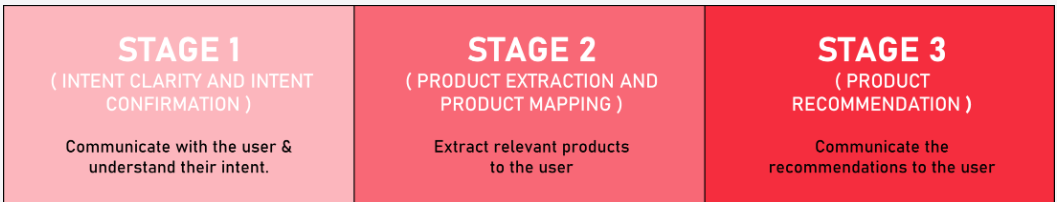

In [1]:
from IPython.display import Image
Image("Chatbot_sys_design.png")

|`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_travel_with_user()`: This function compares the user's profile with the different vacations and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will look at how to write the code for the above functions.

## Part 3: Implementation

## Stage 1

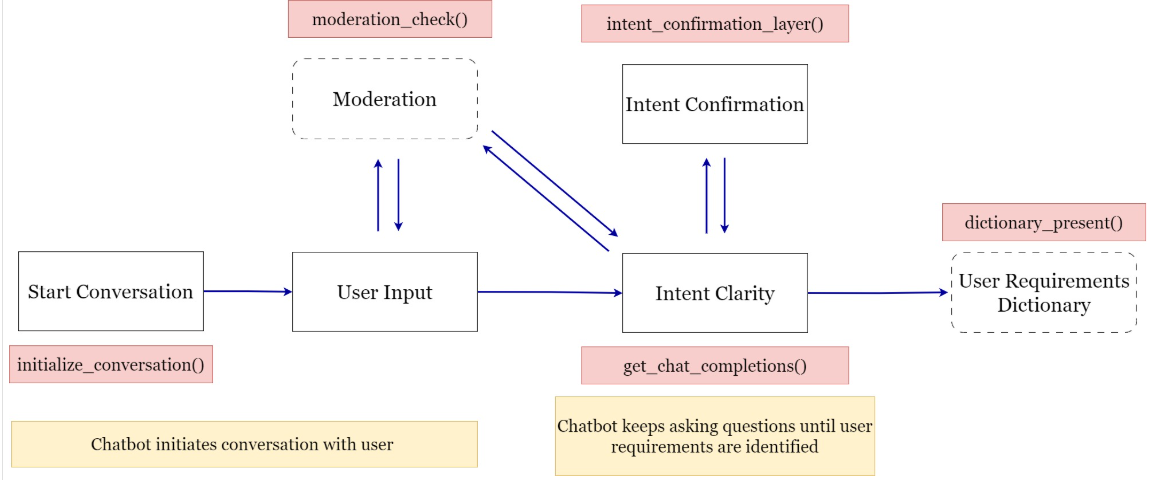

In [2]:
Image("Stage1.png")

### 3.1 - Import the libraries

Let's start by importing the libraries that we'll require for this project. Following are the ones:
- openai
- pandas
- os, json, ast

Make sure the api key is stored in the text file `OPENAI_API_Key.txt`.

In [3]:
# Import the libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [4]:
# Read the OpenAI API key
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [5]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {'Destination Type': "beach",
                         'Budget': "50000",
                         'Travel Duration': "7 days",
                         'Travel Companions': "solo",
                         'Preferred Activities': "adventure"}

    example_user_req = {'Destination Type': "_",
                        'Budget': "_",
                        'Travel Duration': "_",
                        'Travel Companions': "_",
                        'Preferred Activities': "_"}

    system_message = f"""
    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.
    You need to ask relevant questions to understand the user's travel preferences and requirements.
    Your final objective is to fill the values for the different keys ('Destination Type', 'Budget', 'Travel Duration', 'Travel Companions', 'Preferred Activities') in the python dictionary and be confident of the values.
    These key-value pairs define the user's travel profile.
    The python dictionary looks like this:
    {{'Destination Type': 'values', 'Budget': 'values', 'Travel Duration': 'values', 'Travel Companions': 'values', 'Preferred Activities': 'values'}}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    All other keys should have values that align with the user's preferences, such as 'beach', 'mountains', 'luxury', or 'adventure', as inferred from the user's input.
    The example dictionary provided contains representative values only.

    {delimiter}
    Here are some instructions around the values for the keys:
    - The value for 'Budget' should be a numerical value extracted from the user's response.
    - 'Destination Type' should reflect a specific preference such as 'beach', 'mountains', 'city', etc.
    - 'Travel Duration' should clearly indicate the length of the trip in days or weeks.
    - 'Travel Companions' should clarify if the user is traveling 'solo', with 'family', 'friends', or 'partner'.
    - 'Preferred Activities' should include specific preferences like 'adventure', 'relaxation', 'sightseeing', etc.
    - Do not randomly assign values to any of the keys.
    - The values must be inferred from the user's response.

    {delimiter}
    To build the user's travel profile, follow these chain-of-thoughts:
    1. Begin by understanding the user's preferences and requirements. Ask open-ended questions to gather information about their ideal travel experience.
    2. Gradually narrow down the details to fill in the dictionary keys. For instance:
       - Ask about the type of destination they prefer (e.g., 'beach', 'mountains', 'city').
       - Clarify their budget for the trip.
       - Confirm their preferred travel duration.
       - Identify their companions for the trip (if any).
       - Understand the activities they enjoy during vacations (e.g., 'adventure', 'relaxation').
    3. Validate the filled values. If unsure about any key, ask clarifying questions.

    {delimiter}
    Here is an example conversation:
    User: "I want to go on a vacation."
    Assistant: "That sounds exciting! Let's plan your perfect getaway. To start, do you have a specific type of destination in mind, like a beach, mountains, or a city? Or are you open to exploring options?"
    User: "I love beaches."
    Assistant: "Beaches are a fantastic choice for relaxation and fun. Could you share your budget for the trip so I can tailor recommendations accordingly?"
    User: "I can spend up to 50,000 INR."
    Assistant: "Got it! A beach destination within a 50,000 INR budget is possible. How many days do you plan to spend on this trip?"
    User: "I want to go for a week."
    Assistant: "Great! Are you traveling solo or with someone?"
    User: "I'll be traveling solo."
    Assistant: "Noted. Do you prefer a relaxing beach vacation, or are you looking for activities like water sports and adventure?"
    User: "I enjoy adventure activities."
    Assistant: "{example_user_dict}"
    {delimiter}

    Start with a friendly greeting and encourage the user to share their travel preferences and requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    return conversation


Let's see what does `initialize_conversation()` does.

<br>

We have added a prefix `debug_` to each of the variables so that we can play around with the inputs and outputs and it doesn't disturb the main function.

In [6]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.\n    You need to ask relevant questions to understand the user\'s travel preferences and requirements.\n    Your final objective is to fill the values for the different keys (\'Destination Type\', \'Budget\', \'Travel Duration\', \'Travel Companions\', \'Preferred Activities\') in the python dictionary and be confident of the values.\n    These key-value pairs define the user\'s travel profile.\n    The python dictionary looks like this:\n    {\'Destination Type\': \'values\', \'Budget\': \'values\', \'Travel Duration\': \'values\', \'Travel Companions\': \'values\', \'Preferred Activities\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    All other keys should have values that align with the user\'s preferences, such as \'beach\', \'mountains\', \'luxury\', or \'adventure\', as

In [7]:
# Let's look at the content in the debug_conversation key
print(debug_conversation[0]['content'])


    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.
    You need to ask relevant questions to understand the user's travel preferences and requirements.
    Your final objective is to fill the values for the different keys ('Destination Type', 'Budget', 'Travel Duration', 'Travel Companions', 'Preferred Activities') in the python dictionary and be confident of the values.
    These key-value pairs define the user's travel profile.
    The python dictionary looks like this:
    {'Destination Type': 'values', 'Budget': 'values', 'Travel Duration': 'values', 'Travel Companions': 'values', 'Preferred Activities': 'values'}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    All other keys should have values that align with the user's preferences, such as 'beach', 'mountains', 'luxury', or 'adventure', as inferred from the user's input.
    The example dictionary provided contains repres

In [8]:
# Let's initialise conversation
system_message = initialize_conversation()
print(system_message[0]["content"])


    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.
    You need to ask relevant questions to understand the user's travel preferences and requirements.
    Your final objective is to fill the values for the different keys ('Destination Type', 'Budget', 'Travel Duration', 'Travel Companions', 'Preferred Activities') in the python dictionary and be confident of the values.
    These key-value pairs define the user's travel profile.
    The python dictionary looks like this:
    {'Destination Type': 'values', 'Budget': 'values', 'Travel Duration': 'values', 'Travel Companions': 'values', 'Preferred Activities': 'values'}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    All other keys should have values that align with the user's preferences, such as 'beach', 'mountains', 'luxury', or 'adventure', as inferred from the user's input.
    The example dictionary provided contains repres

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [9]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

In [10]:
# Testing the OpenAI functions defined above
input_prompt ='What is the best place to visit in December Month in India?'
messages = [{'role':'user','content':input_prompt}]
# system_message_json_output = """<<. Return output in JSON format.>>"""
# messages[0]['content']+=system_message_json_output
messages

[{'role': 'user',
  'content': 'What is the best place to visit in December Month in India?'}]

In [11]:
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

"There are several great places to visit in India in December, as the weather is typically cool and pleasant during this month. Some popular destinations to consider include:\n\n1. Goa - Known for its beautiful beaches, vibrant nightlife, and Portuguese heritage, Goa is a popular destination for both domestic and international travelers in December.\n\n2. Rajasthan - With its stunning palaces, forts, and desert landscapes, Rajasthan is a must-visit destination in December. You can also experience cultural activities like camel safaris and traditional festivals.\n\n3. Kerala - The tropical paradise of Kerala is perfect for a serene and relaxing holiday in December. You can explore the backwaters, enjoy a houseboat cruise, and indulge in authentic Ayurvedic treatments.\n\n4. Auli - If you're a fan of snow sports, Auli in Uttarakhand is a great destination in December. It offers opportunities for skiing, snowboarding, and trekking in the beautiful Himalayan mountains.\n\n5. Varanasi - For

In [12]:
## Get LLM Outputs - JSON output
get_chat_completions(messages, json_format = True) ## Chat Completions API and return in JSON format

{'output': 'Kerala is one of the best places to visit in December in India. The weather is pleasant with temperature ranging from 24°C to 30°C, making it perfect for exploring the beautiful beaches, backwaters, and hill stations in Kerala. Enjoy traditional Christmas celebrations, boat races, and cultural events in this tropical paradise.'}

### iterate_response() - Helper Function:
We've created a small helper test function to ensure the model's response is consistent.
Uncomment the code blocks and run the function `iterate_response(response)` to check if the response of the `intent_confirmation_layer`is consistent.}

In [13]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

# Example usage: test the consistency of responses from 'intent_confirmation_layer'
# iterate_llm_response(get_chat_completions, messages)

Let's pass the initialized conversation `debug_conversation` and see what is the assistant's response.

In [14]:
debug_user_input = "Hi, I am Avi. I am planning for a Trip."

In [15]:
debug_conversation.append({"role": "user", "content": debug_user_input})
# print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Avi. I am planning for a Trip.


In [16]:
# Let's look at the debug_conversation list
display(debug_conversation)

[{'role': 'system',
  'content': '\n    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.\n    You need to ask relevant questions to understand the user\'s travel preferences and requirements.\n    Your final objective is to fill the values for the different keys (\'Destination Type\', \'Budget\', \'Travel Duration\', \'Travel Companions\', \'Preferred Activities\') in the python dictionary and be confident of the values.\n    These key-value pairs define the user\'s travel profile.\n    The python dictionary looks like this:\n    {\'Destination Type\': \'values\', \'Budget\': \'values\', \'Travel Duration\': \'values\', \'Travel Companions\': \'values\', \'Preferred Activities\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    All other keys should have values that align with the user\'s preferences, such as \'beach\', \'mountains\', \'luxury\', or \'adventure\', 

In [17]:
# Getting the response from the Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

"Hello Avi! That sounds exciting! Let's plan your perfect getaway. To start, could you please share your travel preferences with me? Do you have a specific type of destination in mind, or are you open to exploring different options?"

Let's play around a bit and add the following user's input `debug_user_input` to the conversation `debug_conversation` and see what the assistant responds with.

In [18]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.\n    You need to ask relevant questions to understand the user\'s travel preferences and requirements.\n    Your final objective is to fill the values for the different keys (\'Destination Type\', \'Budget\', \'Travel Duration\', \'Travel Companions\', \'Preferred Activities\') in the python dictionary and be confident of the values.\n    These key-value pairs define the user\'s travel profile.\n    The python dictionary looks like this:\n    {\'Destination Type\': \'values\', \'Budget\': \'values\', \'Travel Duration\': \'values\', \'Travel Companions\': \'values\', \'Preferred Activities\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    All other keys should have values that align with the user\'s preferences, such as \'beach\', \'mountains\', \'luxury\', or \'adventure\', 

Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [19]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [20]:
moderation_check("I want to murder them.")

'Flagged'

Let's test moderation on the `debug_user_input`

In [21]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now test moderation on some other text.

In [22]:
print(moderation_check("I want to kill them."))
print(moderation_check("I want to plan for a trip"))

Flagged
Not Flagged


So, this moderation api may not be perfect but if you ask this to the ChatGPT or it's API (GPT 3.5), it'll not help you with such requests. Remember, moderation should also be applied on the GPT 3.5's output.

Let's now check moderation on the assistant's response `debug_response_assistant`.

In [23]:
moderation_check(debug_response_assistant)

'Not Flagged'

As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget are captured or not. Let's look at the function that helps us verify that.

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's travel profile clearly. Specifically, it checks if the 
    following properties for the user have been captured:
    
    - Destination Type
    - Budget
    - Travel Duration
    - Travel Companions
    - Preferred Activities

In [24]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    allowed_destination_types = {'beach', 'mountains', 'city', 'desert', 'forest'}
    allowed_companions = {'solo', 'family', 'friends', 'partner'}
    allowed_activities = {'adventure', 'relaxation', 'sightseeing', 'luxury', 'cultural'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail. The input text will contain a user's travel preferences captured through the following keys:
    {{
    'Destination Type': 'values',
    'Budget': 'number',
    'Travel Duration': 'values',
    'Travel Companions': 'values',
    'Preferred Activities': 'values'
    }}
    - The value for 'Destination Type' should only be from the allowed values: {allowed_destination_types}.
    - The value for 'Budget' should only be a numerical value.
    - The value for 'Travel Duration' should be a valid duration string like '7 days' or '2 weeks'.
    - The value for 'Travel Companions' should only be from the allowed values: {allowed_companions}.
    - The value for 'Preferred Activities' should only be from the allowed values: {allowed_activities}.
    
    Next, you need to evaluate if the keys have values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    Thought 3 - Think carefully before answering.
    """

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": f"""Here is the input: {response_assistant}"""}
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        response_format={"type": "json_object"},
        seed=1234
    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [25]:
debug_response_assistant

"Hello Avi! That sounds exciting! Let's plan your perfect getaway. To start, could you please share your travel preferences with me? Do you have a specific type of destination in mind, or are you open to exploring different options?"

In [26]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No', 'reason': 'Missing travel preferences.'}

In [27]:
# Printing the value for better clarity
print("Result:",debug_confirmation.get('result'),"\t", "Reason:", debug_confirmation.get('reason'))

Result: No 	 Reason: Missing travel preferences.


Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer() gives yes as a response. Let's see if the following response by the assistant passes the intent_confirmation_layer() test.

In [28]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

In [29]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent Travel Planner AI and your goal is to create a personalized travel plan for the user.\n    You need to ask relevant questions to understand the user\'s travel preferences and requirements.\n    Your final objective is to fill the values for the different keys (\'Destination Type\', \'Budget\', \'Travel Duration\', \'Travel Companions\', \'Preferred Activities\') in the python dictionary and be confident of the values.\n    These key-value pairs define the user\'s travel profile.\n    The python dictionary looks like this:\n    {\'Destination Type\': \'values\', \'Budget\': \'values\', \'Travel Duration\': \'values\', \'Travel Companions\': \'values\', \'Preferred Activities\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    All other keys should have values that align with the user\'s preferences, such as \'beach\', \'mountains\', \'luxury\', or \'adventure\', 

Let's say that after a series of conversations you get the following response from the assistant.

In [30]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present
debug_response_assistant_1 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for your travel preferences:
{{'Destination Type':'beach',
 'Budget':'50000',
 'Travel Duration':'7 days',
 'Travel Companions':'family',
 'Preferred Activities':'relaxation'}}
"""
# Note that you are using double curly braces

print(debug_response_assistant_1)



Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for your travel preferences:
{'Destination Type':'beach',
 'Budget':'50000',
 'Travel Duration':'7 days',
 'Travel Companions':'family',
 'Preferred Activities':'relaxation'}



Do you think it'll pass the `intent_confirmation_layer()` test?

 Let's try it out.

In [31]:
response = intent_confirmation_layer(debug_response_assistant_1)
response.get('result') # Extract the result key from the dictionary

'Yes'

In [32]:
# Example 2 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_2 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for your travel preferences:
{{'Destination Type':'Space',
 'Budget':'80000',
 'Travel Duration':'10 days',
 'Preferred Activities':'adventure'}}
"""
# Note that 'Travel Companions' is missing, causing the result to be 'No'

print(debug_response_assistant_2)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for your travel preferences:
{'Destination Type':'Space',
 'Budget':'80000',
 'Travel Duration':'10 days',
 'Preferred Activities':'adventure'}



In [33]:
intent_confirmation_layer(debug_response_assistant_2)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'No', 'reason': 'Destination Type is not filled correctly'}

Let's now look at the working of `dictionary_present()`.

### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right Vacation using dictionary matching.

In [34]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {'Destination Type': 'beach',
                'Budget': '50000',
                'Travel Duration': '7 days',
                'Travel Companions': 'family',
                'Preferred Activities': 'relaxation'}

    prompt = f"""You are a Python expert. You are provided with an input string.
            Your task is to check if there is a Python dictionary present in the string.
            It will have the following format {user_req}.
            You must extract the relevant values from the input and return only the Python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of 'Budget' is present in the user input.
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'Destination Type': 'beach/mountains/city/adventure/etc.',
            'Budget': 'numerical value',
            'Travel Duration': 'number of days',
            'Travel Companions': 'solo/family/friends/etc.',
            'Preferred Activities': 'relaxation/adventure/sightseeing/etc.'
            }}
            Here are some sample input-output pairs for better understanding:
            {delimiter}
            input 1: - Destination Type: beach - Budget: 50000 INR - Travel Duration: 7 days - Travel Companions: family - Preferred Activities: relaxation
            output 1: {{'Destination Type': 'beach', 'Budget': '50000', 'Travel Duration': '7 days', 'Travel Companions': 'family', 'Preferred Activities': 'relaxation'}}

            input 2: {{'Destination Type': 'mountains', 'Budget': '80000', 'Travel Duration': '10 days', 'Travel Companions': 'solo', 'Preferred Activities': 'adventure'}}
            output 2: {{'Destination Type': 'mountains', 'Budget': '80000', 'Travel Duration': '10 days', 'Travel Companions': 'solo', 'Preferred Activities': 'adventure'}}

            input 3: Here is your travel profile 'Destination Type': 'city','Budget': '120000','Travel Duration': '14 days','Travel Companions': 'friends','Preferred Activities': 'sightseeing'
            output 3: {{'Destination Type': 'city', 'Budget': '120000', 'Travel Duration': '14 days', 'Travel Companions': 'friends', 'Preferred Activities': 'sightseeing'}}
            {delimiter}
            """
    messages = [{"role": "system", "content": prompt},
                {"role": "user", "content": f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format=True)

    return confirmation


Let's start by passing the `debug_response_assistant`.

In [35]:
debug_response_assistant_n = """
{'Destination Type': 'beach',
                'Budget': '50000',
                'Travel Duration': '7 days',
                'Travel Companions': 'family',
                'Preferred Activities': 'relaxation'}
"""

In [36]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Destination Type': 'beach',
 'Budget': '50000',
 'Travel Duration': '7 days',
 'Travel Companions': 'family',
 'Preferred Activities': 'relaxation'}

In [37]:
type(response_dict_n)

dict

What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

Let's quickly take a look at the code that we have run until now.

In [38]:
debug_conversation = initialize_conversation()
debug_user_input = "Hi, I am Avi. I am looking for a vacation."
debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)
debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'output': {'Destination Type': 'beach', 'Budget': '50000', 'Travel Duration': '7 days', 'Travel Companions': 'family', 'Preferred Activities': 'relaxation'}}


So, now that you have the user profile stored in `response_dict_n`. We'll use this to generate recommendations. Before that, we need to create a similar profile for every Vacation. Let's see how we do it.

## Stage 2

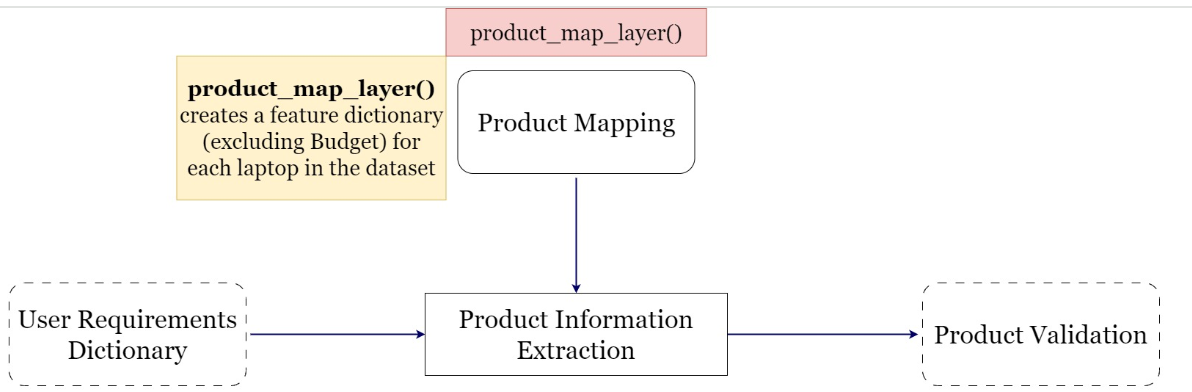

In [39]:
Image('Stage2.png')

### 3.3 Implementing the Product Mapping and Information Extraction Layers

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 3 Vacation recommendations based on user's requirements.

This stage consists of the following helper functions that will implement the information extraction and product matching layers.

### `product_map_layer()`:


This function is designed to extract key travel preferences and criteria from user-provided travel descriptions. 
Below is an explanation of its key components and how it operates:

1. Role Assignment:
   - The function assigns the AI the role of a "Travel Preferences Classifier."
   - The objective is to extract key travel features and classify them based on the user’s travel description.

2. Step-by-Step Extraction:
   - The AI systematically identifies and extracts the following travel preferences:
       a. Destination Type: e.g., Beach, Mountains, City, Adventure, etc.
       b. Budget: A numerical value provided by the user for their travel expenses.
       c. Travel Duration: A specific number of days for the trip.
       d. Travel Companions: e.g., Solo, Family, Friends, etc.
       e. Preferred Activities: e.g., Relaxation, Sightseeing, Adventure, etc.

3. Classification Rules:
   - Predefined rules are applied to classify user preferences accurately:
       a. Destination Type: Categorized based on user’s choice (e.g., mountains, beach).
       b. Budget: Extracted as a numerical value from user input (e.g., "50,000 INR" -> 50000).
       c. Travel Duration: Converts phrases like "a week" into standardized terms such as "7 days."
       d. Travel Companions: Identifies categories like solo, family, or friends based on input.
       e. Preferred Activities: Matches user’s described activities (e.g., trekking, relaxation) to categories.

4. Few-Shot Prompting:
   - Includes sample input-output pairs to demonstrate expected behavior. 
   - Example:
     Input: "I want a solo trip to the mountains with a budget of 50,000 INR, and I enjoy trekking and adventure sports."
     Output: 
     {
         "Destination Type": "mountains",
         "Budget": "50000",
         "Travel Duration": "7 days",
         "Travel Companions": "solo",
         "Preferred Activities": "adventure"
     }

This systematic process ensures the AI captures travel preferences accurately, enabling it to create personalized travel plans effectively.

In [40]:
def product_map_layer(travel_description):
    delimiter = "#####"

    travel_spec = {
        "Destination Type": "(Type of destination, e.g., beach, mountain, city)",
        "Budget": "(Total budget for the trip)",
        "Travel Companions": "(Family, Friends, Solo, Couple)",
        "Travel Duration": "(Number of days)",
        "Preferred Activities": "(Relaxation, Adventure, Sightseeing, Shopping, etc.)",
    }

    values = {'low', 'medium', 'high'}

    prompt = f"""
    You are a Travel Preferences Classifier whose job is to extract the key features of a user's travel description and classify them based on the provided criteria.
    To analyze each travel description, perform the following steps:
    Step 1: Extract the user's primary travel preferences from the description {travel_description}.
    Step 2: Store the extracted preferences in {travel_spec}.
    Step 3: Classify each item in {travel_spec} into {values} where applicable, based on the following rules:
    {delimiter}
    Destination Type:
    - beach: <<< Destinations like tropical islands, coastlines, or resorts >>>.
    - mountain: <<< Destinations with high altitudes, hiking trails, or snow activities >>>.
    - city: <<< Urban centers with museums, shopping, and vibrant nightlife >>>.

    Travel Budget:
    - low: <<< Budget less than 20,000 INR >>>.
    - medium: <<< Budget between 20,000 INR and 70,000 INR >>>.
    - high: <<< Budget greater than 70,000 INR >>>.

    Travel Companions:
    - family: <<< Group includes parents, children, or extended family >>>.
    - friends: <<< Traveling with a group of close friends >>>.
    - solo: <<< Traveling alone >>>.
    - couple: <<< Traveling as a pair >>>.

    Travel Duration:
    - short: <<< Duration less than 3 days >>>.
    - medium: <<< Duration between 3 and 7 days >>>.
    - long: <<< Duration greater than 7 days >>>.

    Preferred Activities:
    - relaxation: <<< Activities such as spa, lounging by the beach, or light exploration >>>.
    - adventure: <<< Activities like hiking, water sports, or extreme sports >>>.
    - sightseeing: <<< Visiting historical landmarks, museums, or cultural sites >>>.
    - shopping: <<< Exploring malls, local markets, or retail destinations >>>.
    {delimiter}

    {delimiter}
    Here is an example input-output pair for few-shot learning:
    input 1: "I am planning a family trip to a beach destination for 5 days. I love relaxing and sightseeing, and my budget is around 60,000 INR."
    output 1: {{
        "Destination Type": "beach",
        "Travel Budget": "medium",
        "Travel Companions": "family",
        "Travel Duration": "medium",
        "Preferred Activities": "relaxation, sightseeing"
    }}
    {delimiter}
    ### Ensure that the output is in a JSON format matching the above schema strictly. ###
    """

    input_data = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {travel_spec} for the following travel description: {travel_description}."""
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": input_data}]

    response = get_chat_completions(messages, json_format=True)

    return response


Let's test this for one sample Vacation description.

In [41]:
travel_description_1 = f"""
I am planning a family trip to a tropical beach destination for a week-long vacation.
We are looking for a relaxing getaway with activities like lounging by the beach and casual sightseeing.
Our budget is around 60,000 INR, and we would prefer a destination with good amenities and child-friendly attractions.
"""

In [42]:
display(product_map_layer(travel_description_1))

{'Destination Type': 'beach',
 'Budget': 'medium',
 'Travel Companions': 'family',
 'Travel Duration': 'medium',
 'Preferred Activities': 'relaxation, sightseeing'}

In [43]:
# # Data type of the output response
print(type(product_map_layer(travel_description_1)))

<class 'dict'>


In [44]:
# # Check for consistency with iterate_response function
iterate_llm_response(product_map_layer, travel_description_1)

Iteration: 0
{'Destination Type': 'beach', 'Budget': 'medium', 'Travel Companions': 'family', 'Travel Duration': 'medium', 'Preferred Activities': 'relaxation, sightseeing'}
--------------------------------------------------
Iteration: 1
{'Destination Type': 'beach', 'Budget': 'medium', 'Travel Companions': 'family', 'Travel Duration': 'medium', 'Preferred Activities': 'relaxation, sightseeing'}
--------------------------------------------------
Iteration: 2
{'Destination Type': 'beach', 'Budget': 'medium', 'Travel Companions': 'family', 'Travel Duration': 'medium', 'Preferred Activities': 'relaxation, sightseeing'}
--------------------------------------------------
Iteration: 3
{'Destination Type': 'beach', 'Budget': 'medium', 'Travel Companions': 'family', 'Travel Duration': 'medium', 'Preferred Activities': 'relaxation, sightseeing'}
--------------------------------------------------
Iteration: 4
{'Destination Type': 'beach', 'Budget': 'medium', 'Travel Companions': 'family', 'Trave

Let's now apply this function to the entire Vacation dataset

In [45]:
##Run this code once to extract product info in the form of a dictionary
import pandas as pd
travel_df= pd.read_csv('Travel_Data.csv')

## Create a new column "travel_feature" that contains the dictionary of the product features
travel_df['travel_feature'] = travel_df['Description'].apply(lambda x: product_map_layer(x))

In [46]:
travel_df.to_csv("updated_travel.csv",index=False,header = True)

### `compare_vacation_with_user()`:

This function compares the user's profile with the different Vacations and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the Vacation based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each Vacation based on how well it matches the user's requirements.
    - Sort the Vacation based on their scores in descending order.
    - Return the top 3 Vacation as a JSON-formatted string.

In [47]:
import pandas as pd  
import json

def compare_travel_with_user(user_req_dict):
    travel_df = pd.read_csv('updated_travel.csv')
    user_requirements = user_req_dict  
    travel_budget_mapping = {'low': 0, 'medium': 1, 'high': 2}
    travel_duration_mapping = {'short': 0, 'medium': 1, 'long': 2}
    activities_mapping = {'relaxation': 1, 'sightseeing': 1, 'adventure': 2, 'exploration': 2}
    budget = travel_budget_mapping.get(user_requirements.get('Budget', 'medium').lower(), 1)
    duration = travel_duration_mapping.get(user_requirements.get('Travel Duration', 'medium').lower(), 1)
    filtered_travel = travel_df.copy()
    filtered_travel['BudgetScore'] = filtered_travel['Budget'].apply(lambda x: travel_budget_mapping.get(str(x).lower(), 1))
    filtered_travel['DurationScore'] = filtered_travel['Duration'].apply(lambda x: travel_duration_mapping.get(str(x).lower(), 1))
    filtered_travel['Score'] = 0
    for index, row in filtered_travel.iterrows():
        score = 0
        if row['BudgetScore'] >= budget:
            score += 1
        if row['DurationScore'] >= duration:
            score += 1
        
        
        filtered_travel.loc[index, 'Score'] = score  

    top_travel_destinations = filtered_travel.sort_values('Score', ascending=False).head(3)

    top_travel_json = top_travel_destinations.to_json(orient='records')  

    return top_travel_json

Now that you have the `compare_vacation_with_user()` function ready, let's pass the `response_dict_n` to the function to get top 3 recommendation.

In [48]:
display(response_dict_n, '\n',type(response_dict_n))

{'output': {'Destination Type': 'beach',
  'Budget': '50000',
  'Travel Duration': '7 days',
  'Travel Companions': 'family',
  'Preferred Activities': 'relaxation'}}

'\n'

dict

In [49]:
dictionary_present(response_dict_n)

{'output': {'Destination Type': 'beach',
  'Budget': '50000',
  'Travel Duration': '7 days',
  'Travel Companions': 'family',
  'Preferred Activities': 'relaxation'}}

In [50]:
top_3_vacations = compare_travel_with_user(response_dict_n)

display(top_3_vacations)

'[{"Uniq Id":"0eaaee0a8a6ba47cfc9f6e6852fcf9f0","Duration":7,"Crawl Timestamp":"2019-09-19 23:07:23 +0000","Package Name":"A Grand Week in North East - Lachung Special","Page Url":"https:\\/\\/holidayz.makemytrip.com\\/holidays\\/india\\/package?id=26923&depCityId=1218&listingClassId=10&depDateMilliSec=1569974400000","Package Type":"Deluxe","Company":"Makemytrip","Destination":"Gangtok|Lachung|Gangtok|Darjeeling","Itinerary":"2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling","Places Covered":"Gangtok|Lachung|Gangtok|Darjeeling","Travel Date":"2\\/10\\/2019","Hotel Details":"Lemon Tree Hotel  Gangtok:4.2|Summit Alpine Resort, Lachung- MMT Holidays Special:4.2|Lemon Tree Hotel  Gangtok:4.4|Ramada by Wyndham Darjeeling Gandhi Road:","Start City":"New Delhi","Airline":"IndiGo","Flight Stops":null,"Onwards Return Flight Time":"14 : 00-16 : 05","Meals":null,"Budget":71350,"Per Person Price":35675.0,"Sightseeing Places Covered":" Baba Mandir | MG Road - Walk | Visit to Lake Tsomgo with Ya

In [51]:
# Get output in JSON Format
top_3_vacations_json = json.loads(top_3_vacations)
top_3_vacations_json

[{'Uniq Id': '0eaaee0a8a6ba47cfc9f6e6852fcf9f0',
  'Duration': 7,
  'Crawl Timestamp': '2019-09-19 23:07:23 +0000',
  'Package Name': 'A Grand Week in North East - Lachung Special',
  'Page Url': 'https://holidayz.makemytrip.com/holidays/india/package?id=26923&depCityId=1218&listingClassId=10&depDateMilliSec=1569974400000',
  'Package Type': 'Deluxe',
  'Company': 'Makemytrip',
  'Destination': 'Gangtok|Lachung|Gangtok|Darjeeling',
  'Itinerary': '2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling',
  'Places Covered': 'Gangtok|Lachung|Gangtok|Darjeeling',
  'Travel Date': '2/10/2019',
  'Hotel Details': 'Lemon Tree Hotel  Gangtok:4.2|Summit Alpine Resort, Lachung- MMT Holidays Special:4.2|Lemon Tree Hotel  Gangtok:4.4|Ramada by Wyndham Darjeeling Gandhi Road:',
  'Start City': 'New Delhi',
  'Airline': 'IndiGo',
  'Flight Stops': None,
  'Onwards Return Flight Time': '14 : 00-16 : 05',
  'Meals': None,
  'Budget': 71350,
  'Per Person Price': 35675.0,
  'Sightseeing Places Covered':

### `product_validation_layer()`:

This function verifies that the Vacation recommendations are good enough, has score greater than or equal to 2, and matches the user's requirements.

In [52]:
def recommendation_validation(Travel_recommendation):
    data = json.loads(Travel_recommendation)
    data1 = []
    for i in range(len(data)):
        if data[i]['Score'] >= 2:
            data1.append(data[i])

    return data1

In [53]:
validated_data = recommendation_validation(top_3_vacations)
display(validated_data,'\n')

[{'Uniq Id': '0eaaee0a8a6ba47cfc9f6e6852fcf9f0',
  'Duration': 7,
  'Crawl Timestamp': '2019-09-19 23:07:23 +0000',
  'Package Name': 'A Grand Week in North East - Lachung Special',
  'Page Url': 'https://holidayz.makemytrip.com/holidays/india/package?id=26923&depCityId=1218&listingClassId=10&depDateMilliSec=1569974400000',
  'Package Type': 'Deluxe',
  'Company': 'Makemytrip',
  'Destination': 'Gangtok|Lachung|Gangtok|Darjeeling',
  'Itinerary': '2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling',
  'Places Covered': 'Gangtok|Lachung|Gangtok|Darjeeling',
  'Travel Date': '2/10/2019',
  'Hotel Details': 'Lemon Tree Hotel  Gangtok:4.2|Summit Alpine Resort, Lachung- MMT Holidays Special:4.2|Lemon Tree Hotel  Gangtok:4.4|Ramada by Wyndham Darjeeling Gandhi Road:',
  'Start City': 'New Delhi',
  'Airline': 'IndiGo',
  'Flight Stops': None,
  'Onwards Return Flight Time': '14 : 00-16 : 05',
  'Meals': None,
  'Budget': 71350,
  'Per Person Price': 35675.0,
  'Sightseeing Places Covered':

'\n'

Now that you the top 3 Vacations extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

## Stage 3

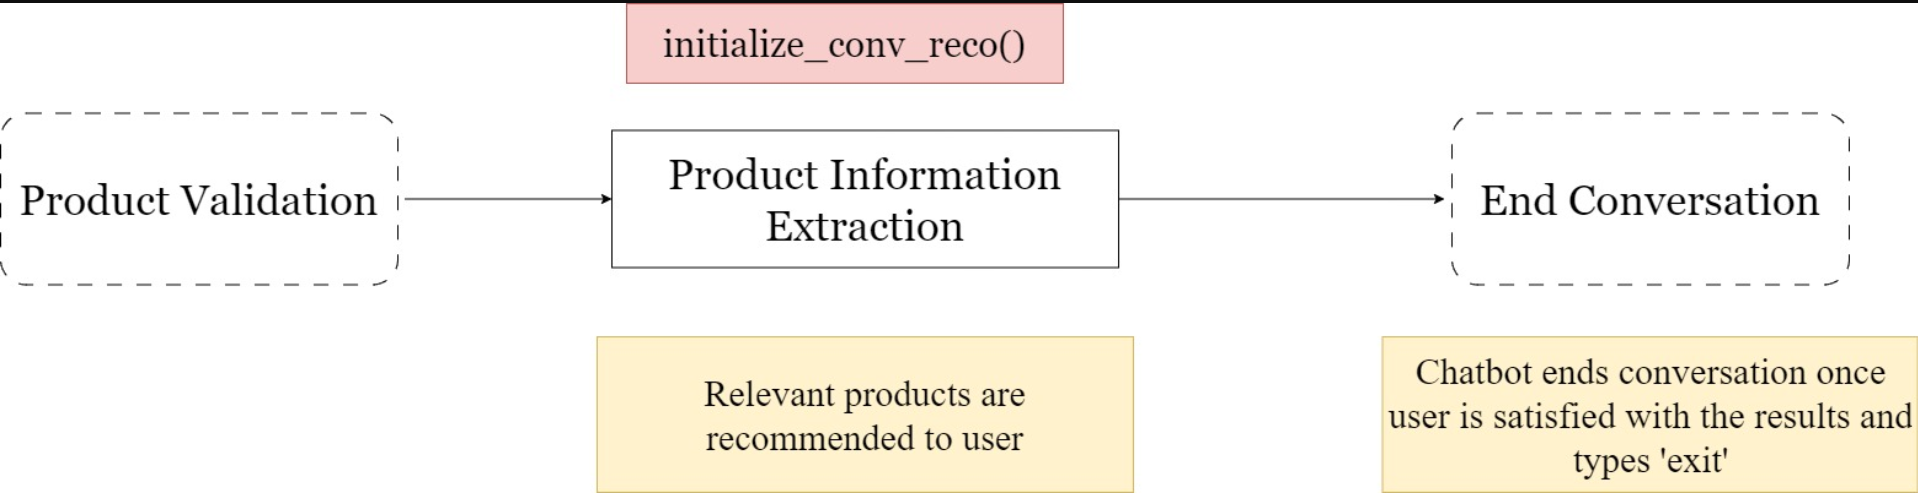

In [54]:
Image('Stage3.png')

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_travel_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



In [55]:
def initialize_conv_reco(travel_options):
    system_message = f"""
    You are an intelligent travel planner and you are tasked with the objective to \
    solve the user queries about any destination or trip from the travel options list in the user message. \
    You should consider the user's travel preferences, budget, and other relevant factors while answering the questions.

    Start with a brief summary of each destination or trip in the following format, in decreasing order of price:
    1. <Destination Name> : <Major attractions/activities>, <Price in Rs>
    2. <Destination Name> : <Major attractions/activities>, <Price in Rs>
    
    """
    user_message = f""" These are the user's preferred travel options: {travel_options}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    return conversation


Let's initialize the conversation for recommendation.

In [56]:
debug_conversation_reco = initialize_conv_reco(top_3_vacations)
debug_conversation_reco

[{'role': 'system',
  'content': "\n    You are an intelligent travel planner and you are tasked with the objective to     solve the user queries about any destination or trip from the travel options list in the user message.     You should consider the user's travel preferences, budget, and other relevant factors while answering the questions.\n\n    Start with a brief summary of each destination or trip in the following format, in decreasing order of price:\n    1. <Destination Name> : <Major attractions/activities>, <Price in Rs>\n    2. <Destination Name> : <Major attractions/activities>, <Price in Rs>\n    \n    "},
 {'role': 'user',
  'content': ' These are the user\'s preferred travel options: [{"Uniq Id":"0eaaee0a8a6ba47cfc9f6e6852fcf9f0","Duration":7,"Crawl Timestamp":"2019-09-19 23:07:23 +0000","Package Name":"A Grand Week in North East - Lachung Special","Page Url":"https:\\/\\/holidayz.makemytrip.com\\/holidays\\/india\\/package?id=26923&depCityId=1218&listingClassId=10&dep

Let's see what the assistant responds with the new initialization.

In [57]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

1. A Grand Week in North East - Lachung Special: Baba Mandir, MG Road - Walk, Visit to Lake Tsomgo with Yak Safari, Yumthang Valley, Hot Spring, Price: Rs 35,675 per person
2. A Relaxing holiday to Kerala - Free Speed Boat Ride: Dutch Palace, St. Francis Church, Mattupetty Dam, Tata Tea Museum, Periyar wildlife Sanctuary, Speed Boat Ride at Mattupetty Dam and Drive to Top Station in Munnar, Kalari Show, Price: Rs 16,432 per person
3. Experiential Manali from Chandigarh (Candid Photography): Vashishth Kund, Hadimba Temple, Tibetan Monastery, Personal Photoshoot in Manali, Solang Valley, Price: Rs 6,022.5 per person

Based on your preferences for a family trip to a beautiful mountain destination for a week-long vacation with activities like relaxation and scenic sightseeing, I would recommend considering the "A Grand Week in North East - Lachung Special" package. It offers a peaceful retreat in Gangtok, Lachung, and Darjeeling with various sightseeing attractions within your budget of ar

Now, you can converse with the chatbot on the filtered products.

In [58]:
response_dict_n

{'output': {'Destination Type': 'beach',
  'Budget': '50000',
  'Travel Duration': '7 days',
  'Travel Companions': 'family',
  'Preferred Activities': 'relaxation'}}

In [59]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [60]:
debug_user_input = "Which is ideal for travel?"

In [61]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nBased on your preferences for a family trip to a beach destination for a relaxing getaway with activities like water activities, relaxation, and sightseeing, the "A Relaxing holiday to Kerala - Free Speed Boat Ride" package would be ideal for your travel. It offers a relaxing itinerary covering Cochin, Munnar, Thekkady, Allepey, Kovalam, and Poovar with beach and backwaters experiences, including a Speed Boat Ride at Mattupetty Dam and visits to various sightseeing attractions. This package aligns well with your preferences and budget of around 30,000 INR for a week-long vacation.\n'

You can repeat the process of appending the assistant and user messages and test the chatbot out.

## Combining all the 3 stages

In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [62]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    display(introduction + '\n')

    top_3_vacations = None

    user_input = ''

    while(user_input != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_vacations is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_vacations = compare_travel_with_user(response)

                print("top 3 Vacations are", top_3_vacations)

                validated_reco = recommendation_validation(top_3_vacations)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [63]:
dialogue_mgmt_system()

"Hello! Planning a vacation is always exciting! \nLet's create a personalized travel plan just for you. \nTo get started, could you please tell me about your ideal travel experience? \nWhat type of destination do you prefer - such as beach, mountains, city, or anything else that comes to mind?Feel free to share your thoughts!\n"

 beach


Intent Confirmation Yes/No: No

That's a great choice! Beach destinations are perfect for relaxation and fun. Could you please share your budget range for this trip so I can help you plan accordingly?



 50000


Intent Confirmation Yes/No: No

Great! A budget of 50,000 INR opens up some exciting beach destinations. How long do you plan to spend on this trip?



 7 days


Intent Confirmation Yes/No: No

Sounds like a perfect week-long getaway! Will you be traveling solo or with someone?



 family


Intent Confirmation Yes/No: No

Traveling with family can be a wonderful experience! Do you prefer a relaxing beach vacation or are you looking for activities like water sports and adventure?



 relaxation


Intent Confirmation Yes/No: Yes

Fantastic! Based on your preferences, here is a personalized travel plan for you:
- Destination Type: beach
- Budget: 50000
- Travel Duration: 7 days
- Travel Companions: family
- Preferred Activities: relaxation

Does this travel profile accurately represent your ideal vacation?


Variables extracted!

Thank you for providing all the information. Kindly wait, while I fetch the products: 

top 3 Vacations are [{"Uniq Id":"0eaaee0a8a6ba47cfc9f6e6852fcf9f0","Duration":7,"Crawl Timestamp":"2019-09-19 23:07:23 +0000","Package Name":"A Grand Week in North East - Lachung Special","Page Url":"https:\/\/holidayz.makemytrip.com\/holidays\/india\/package?id=26923&depCityId=1218&listingClassId=10&depDateMilliSec=1569974400000","Package Type":"Deluxe","Company":"Makemytrip","Destination":"Gangtok|Lachung|Gangtok|Darjeeling","Itinerary":"2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling","Places Covered":"Gangtok|Lachung|Gangtok|Darjeeling","Travel Date":"2\/10\/

 exit



If you have any more questions in the future, feel free to ask. Have a great day! Goodbye!

